In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import datetime
import random
from scipy import stats
import math
import nbimporter
from Modelling_Utils import get_xCCDF,find_opt_params,funcD,funcD_noC,get_results_PL_exp
import seaborn as sns

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
pd.options.display.max_rows = 4000

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

## MiD Data reading
Mobilität in Deutschland

The loading of this data set requires you to have acquired the MiD 2017 data, which is not public and must be requested via https://www.mobilitaet-in-deutschland.de/archive/index.html. Only execute these code blocks in case you acquired the data set.

In [4]:
# # MiD data reading
df_MiD=pd.read_csv('data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2'])
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
# Different transport modes extraction
df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True]
df_MiD_car=df_MiD[df_MiD.hvm.isin([4]) == True] #Car
# long range concat
df_MiD_LR=pd.concat([df_MiD_car,df_MiD_LRpublic])
df_MiD_LR.head(2)

,wegkm,hvm,hvm_diff2
0,21.85,4,9
2,21.85,4,9


## Configurations for modelling
Please note the different configurations used for each model.
To train the dynamically truncated power-law model, uncomment the part labeled “Configuration used to test the dynamically truncated power-law.”

In [5]:
# Parameter combinations tested during modelling
# Configuration used in our tests of the distance-amplified model
eps_range=np.arange(0.1,2,0.1) #note that (1+eps) is equal to amplification parameter C described in the paper
p_range=np.arange(0.01, 0.99, 0.05)
alp_range=np.arange(1.4,2.51,0.05)

# Configuration used to test the dynamically truncated power-law
# eps_range=[1]
# p_range=[0]
# alp_range=np.arange(1.2,2.51,0.05)

# create an array of all parameter combinations to consider
# error is initialized to 0 and will be replaced later on
err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list

# Maximum and minimum distance
df_vec=df_MiD_LR['wegkm'].copy() # Long distance in MiD 2017
min_distance=100 
max_distance=900
maxdistance=900

# SampleSize: number of samples generated per parameter combination
sampleSize=50000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]
print("MiD dataset size used: ",len(df_vec))


MiD dataset size used:  11008


## Model Training and Storage

In [6]:
# get the max range of trip length in the error calculation
max_d=800
print('The max range of trip length in the error calculation', max_d)
#the number of sampling points in error calculation
num=1000

The max range of trip length in the error calculation 800


### Our model & Power-law with dynamic truncation
The parameters and values of the best-fitting processes are stored in a file. As the modelling procedure contains a parameter search this may take time to execute. For convenience, we also provided the `.pkl` files containing the results we obtained, allowing this and next section to be skipped.

In [ ]:
%%time
# Call the function to start the process
result = find_opt_params(combinable, sampleSize, min_distance, maxdistance, df_vec,max_d,num)
df_com=pd.DataFrame(result)
com=df_com.values

# The lowest error and corresponding parameters to get the optimal error
idx_best=com[:,3].argmin() #error

# the results contain the value of eps,p, alpha errors and list of simulated trip length
opt_modelling=pd.DataFrame(result[idx_best])
# opt_modelling.to_pickle(res+'Optimal results of LR Modelling in MiD17 with car.pkl')
# opt_modelling.to_pickle(res+'Optimal results of Power-law with dynamic truncation for LR Modelling in MiD17 with car.pkl')

### Power-law with exponential truncation

In [7]:
# Settings for MiD with car
alphas=np.arange(1.01, 1.091,0.01) 
gammas=np.arange(200, 1501,20)
Ds=np.arange(100,2001,1) #distance trips setted for MiD

In [8]:
%%time
opt_PLE_results=get_results_PL_exp(alphas,gammas,Ds,df_vec,max_d,num)
opt_PLE_results.to_pickle(res+"Optimal power-law with exponential truncation in MiD.pkl")

CPU times: user 4min 47s, sys: 4.96 s, total: 4min 52s
Wall time: 4min 52s


# Plotting

In [16]:
'''CCDF plotting
This script generates and displays the CCDF plots below, and saves them to the “results” folder.

Input:
    datalist: a list of datasets
    labels: a list of corresponding data name for each dataset
    Ds,C,alpha,gamma: parameters from the exponentially truncated power-law model 
    max_d: the maximum trip length used in the sMAPE error calculation
    num: the number of sampling points used in the sMAPE error calculation 

'''
def ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d):
    fig, ax = plt.subplots(figsize=(3.54*1.5,2.83*1.5))
    colors=['#1f77b4','red','#2ca02c']
    linestyles=['solid','dashdot','dotted']
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
        ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the optimal results for powerlaw with exponential truncation
    Fd=[0]*len(Ds)
    for idx,d in enumerate(Ds):
        for i in Ds[Ds>=d]:
            Fd[idx]+=funcD(C,i,alpha,gamma)
    ax.plot(Ds,Fd,label='Power-law [E]',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.6,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    leg = ax.legend(title='MiD Long Distance',loc='lower right',alignment='left',framealpha=0.2)
    
    leg.get_title().set_fontsize('15')
    
    # plt.yscale("log")
    # plt.xscale("log")
    # plt.ylim(bottom=1e-03) 
    plt.xlim(right=1e+3)  
    plt.tight_layout()
    # plt.savefig(res+'CCDF_MiD_4Lines_log.pdf', dpi=100, bbox_inches='tight')
    plt.savefig(res+'CCDF_MiD_4Lines_normal.pdf', dpi=100, bbox_inches='tight')
    

In [7]:
'''
Data and optimal parameters reading from the stored files
You can find them in the folder "results"
'''
# Data and model reading---MiD
df_vec=df_MiD_LR['wegkm'].copy() # Long distance in MiD 2017 with car
min_distance=100
max_distance=900
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
# opt_model=pd.read_pickle(res+'Optimal results of LR modelling in MiD17.pkl')
opt_model=pd.read_pickle(res+'Optimal results of LR Modelling in MiD17 with car.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# power-law with our truncation
opt_model_pl=pd.read_pickle(res+'Optimal results of Power-law with dynamic truncation for LR Modelling in MiD17 with car.pkl')
optM_pl=np.array(opt_model_pl)
#Optimal result, which error is the lowest
eps_pl = optM_pl[0,0]
p_pl = optM_pl[1,0]
alp_pl = optM_pl[2,0]
dist_pl= optM_pl[4,0] #optimal trips list

print(len(df_vec))
print("MiD Our model: ",eps,p,alp,optM[3,0])
print("MiD Power-law [D]: ",eps_pl,p_pl,alp_pl,optM_pl[3,0])

11008
MiD Our model:  0.8 0.56 1.9500000000000002 0.05390194151720362
MiD Power-law [D]:  1 0 1.8000000000000005 0.07427249554139317


CPU times: user 1.56 s, sys: 52.7 ms, total: 1.61 s
Wall time: 1.01 s


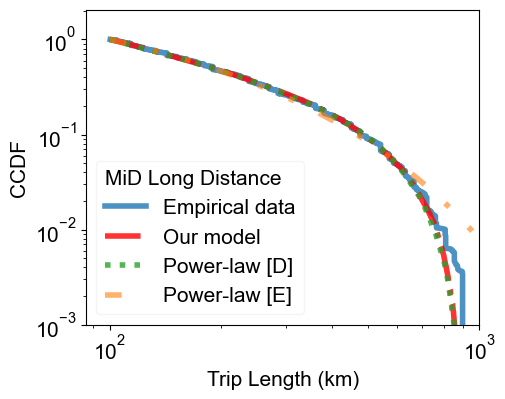

In [13]:
%%time
datalist=[df_vec,dist,dist_pl]
labels=['Empirical data','Our model','Power-law [D]']

# Reading the stored optimal power-law with exponential truncation fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal power-law with exponential truncation in MiD.pkl')
#optimal alpha and gamma
alpha=opt_trunc.alpha
gamma=opt_trunc.gamma
C=opt_trunc.C
Ds = np.arange(100,2001,1) #distance trips setted

# log-log plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)

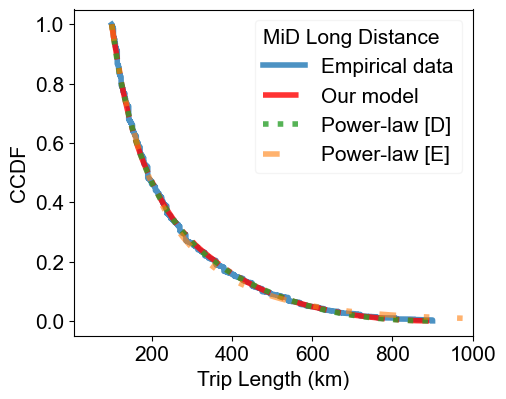

In [15]:
# normal plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)